# Flu Shot or Not?

## Introducing the Business Problem

263 million of Covid-19 vaccines were thrown away in March, 2022 (Ref). 798 million of H1N1 vaccines (Ref) are sitting, unused, in inventory. On the other hand, the 2004-2005 flu vaccine shortage was responsible for 34,200 lives (Ref). In todays data-driven society,  these numbers are way to high.Ideally, our Vaccine Demand Forecasting can be used in supply chains to meet demand more accurately with the purpose of reducing the costs involved with the business problem. 

This Notebook will contain many parts, first we will define our business question and then we will dive into our exploratory data analysis (EDA). The iterative modeling process will be reviewed in detail and its potential impact will be discussed thoroughly. That discussion will serve as the foundation for some recommendations, and delve into some potential next steps.To gain an even better overview of the entire analysis,  I invite you peruse the entire Git Hub [Repository](https://github.com/nishlikefish/H1N1_flu_project), the slides for our presentation and our Tableau Dashboard. 

## Business Question 

With that in mind, let's move on to the business question: what factors influence demand for the flu vaccine and how can they be utilized to predict it?

## Data Overview

The data's original form was actually in 3 separate csv files. The first file name is "training_set_features" and it contains the input variables that our model will use to predict the probability that people received H1N1 flu and seasonal flu vaccines.There are 35 feature columns in total, each a response to a survey question. These questions cover several different topics, such as whether people observed safe behavioral practices, their opinions about the diseases and the vaccines, and data about their demographics.

The second file name is "training_set_labels" are the labels corresponding to the observations in the training features. There are two target variables in this data set: h1n1_vaccine and seasonal_vaccine.Both are binary variables, with 1 indicating that a person received the respective flu vaccine and 0 indicating that a person did not receive the respective flu vaccine. For the purpose of this notebook, we will focus on just the seasonal_vaccine as the target for our model. 

"test_set_features" is the name of our third file and it contains the features for observations that we would haved  used to generate predictions after training a model (Holdout set). However,since we are only building one model, we cannot submit to Kaggle to get test against its corresponding target variable values. Due to this, the training features and labels will be our entire data set for this notebook and a train-test-split will be performed to get training and test sets. 

### Exploratory Data Analysis

#### Imports

In [42]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer,OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import plot_confusion_matrix, recall_score,\
    accuracy_score, precision_score, f1_score,plot_roc_curve, roc_auc_score

from imblearn.over_sampling import SMOTE

from sklearn.multioutput import MultiOutputClassifier

from sklearn.feature_selection import RFE

from xgboost.sklearn import XGBClassifier
from sklearn.neural_network import MLPClassifier
RANDOM_SEED = 8    # Set a random seed for reproducibility!

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import StackingClassifier,VotingClassifier,BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from numpy import nan
import copy


In [43]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

We want to import warnings to increase readability and ensure the structure and flow of the notebook remain uninterrupted.

In [44]:
pd.set_option("display.max_columns", 100) 

### Loading the data

In [45]:
tr_features = pd.read_csv('data/training_set_features.csv')

In [46]:
tr_features.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,2.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,3.0,3.0,5.0,5.0,4.0,1.0,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,3.0,2.0,3.0,1.0,4.0,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb


In [47]:
tr_features.shape

(26707, 36)

Each row is a person who was a survey respondent. The columns are the feature values corresponding to those people. We have 26,707 observations and 35 features

In [48]:
tr_features.dtypes

respondent_id                    int64
h1n1_concern                   float64
h1n1_knowledge                 float64
behavioral_antiviral_meds      float64
behavioral_avoidance           float64
behavioral_face_mask           float64
behavioral_wash_hands          float64
behavioral_large_gatherings    float64
behavioral_outside_home        float64
behavioral_touch_face          float64
doctor_recc_h1n1               float64
doctor_recc_seasonal           float64
chronic_med_condition          float64
child_under_6_months           float64
health_worker                  float64
health_insurance               float64
opinion_h1n1_vacc_effective    float64
opinion_h1n1_risk              float64
opinion_h1n1_sick_from_vacc    float64
opinion_seas_vacc_effective    float64
opinion_seas_risk              float64
opinion_seas_sick_from_vacc    float64
age_group                       object
education                       object
race                            object
sex                      

The data set i worked with was from the 2009 swine flu health survey. It contains both numeric and categorical variables as well as survey data that contain information such as opinions on both the h1n1 vaccine and the seasonal flu vaccine. Each types of data was treated differently to optimize our models performance.

In [49]:
tr_labels =pd.read_csv('data/training_set_labels.csv')
tr_labels.head()

,respondent_id,h1n1_vaccine,seasonal_vaccine
0,0,0,0
1,1,0,1
2,2,0,0
3,3,0,1
4,4,0,0


In [50]:
tr_labels.shape

(26707, 3)

We have the same 26,707 observations, and two target variables that we have labels for.Let's double-check that the rows between the features and the labels match up. We don't want to have the wrong labels. Numpy's assert_array_equal will error if the two arrays—the row indices of the two data frames—don't match up.

In [51]:
np.testing.assert_array_equal(tr_features.index.values, tr_labels.index.values)

## Data Cleaning and Preparation

### Handling Missing Values

In [52]:
(tr_features.isna().sum())/len(tr_features)

respondent_id                  0.000000
h1n1_concern                   0.003445
h1n1_knowledge                 0.004343
behavioral_antiviral_meds      0.002658
behavioral_avoidance           0.007788
behavioral_face_mask           0.000711
behavioral_wash_hands          0.001573
behavioral_large_gatherings    0.003258
behavioral_outside_home        0.003070
behavioral_touch_face          0.004793
doctor_recc_h1n1               0.080878
doctor_recc_seasonal           0.080878
chronic_med_condition          0.036358
child_under_6_months           0.030704
health_worker                  0.030104
health_insurance               0.459580
opinion_h1n1_vacc_effective    0.014640
opinion_h1n1_risk              0.014528
opinion_h1n1_sick_from_vacc    0.014790
opinion_seas_vacc_effective    0.017299
opinion_seas_risk              0.019246
opinion_seas_sick_from_vacc    0.020107
age_group                      0.000000
education                      0.052683
race                           0.000000


write something about table above

#### Health Insurance

In [53]:
tr_features['health_insurance']=tr_features['health_insurance'].fillna(value=0).value_counts() 

This filling of the missing values is because if its Nan i made the assumption that this participant does not have health insurance and therefore their value should be ). This is congruent with a major issue in the current healthcare landscape. the unequal distribution of healthcare in this country. 

With that assumption made, the dataset shows that over half of the participants in the survey did not have health insurance. This not only results in holes in my raw data but also makes it very difficult to differentiate the people who are choosing not be vaccinated as opposed to not having access to vaccines. 

### Handling Categorical Variables

In [55]:
joined_df=(tr_features).join(tr_labels,on='respondent_id',lsuffix="x")

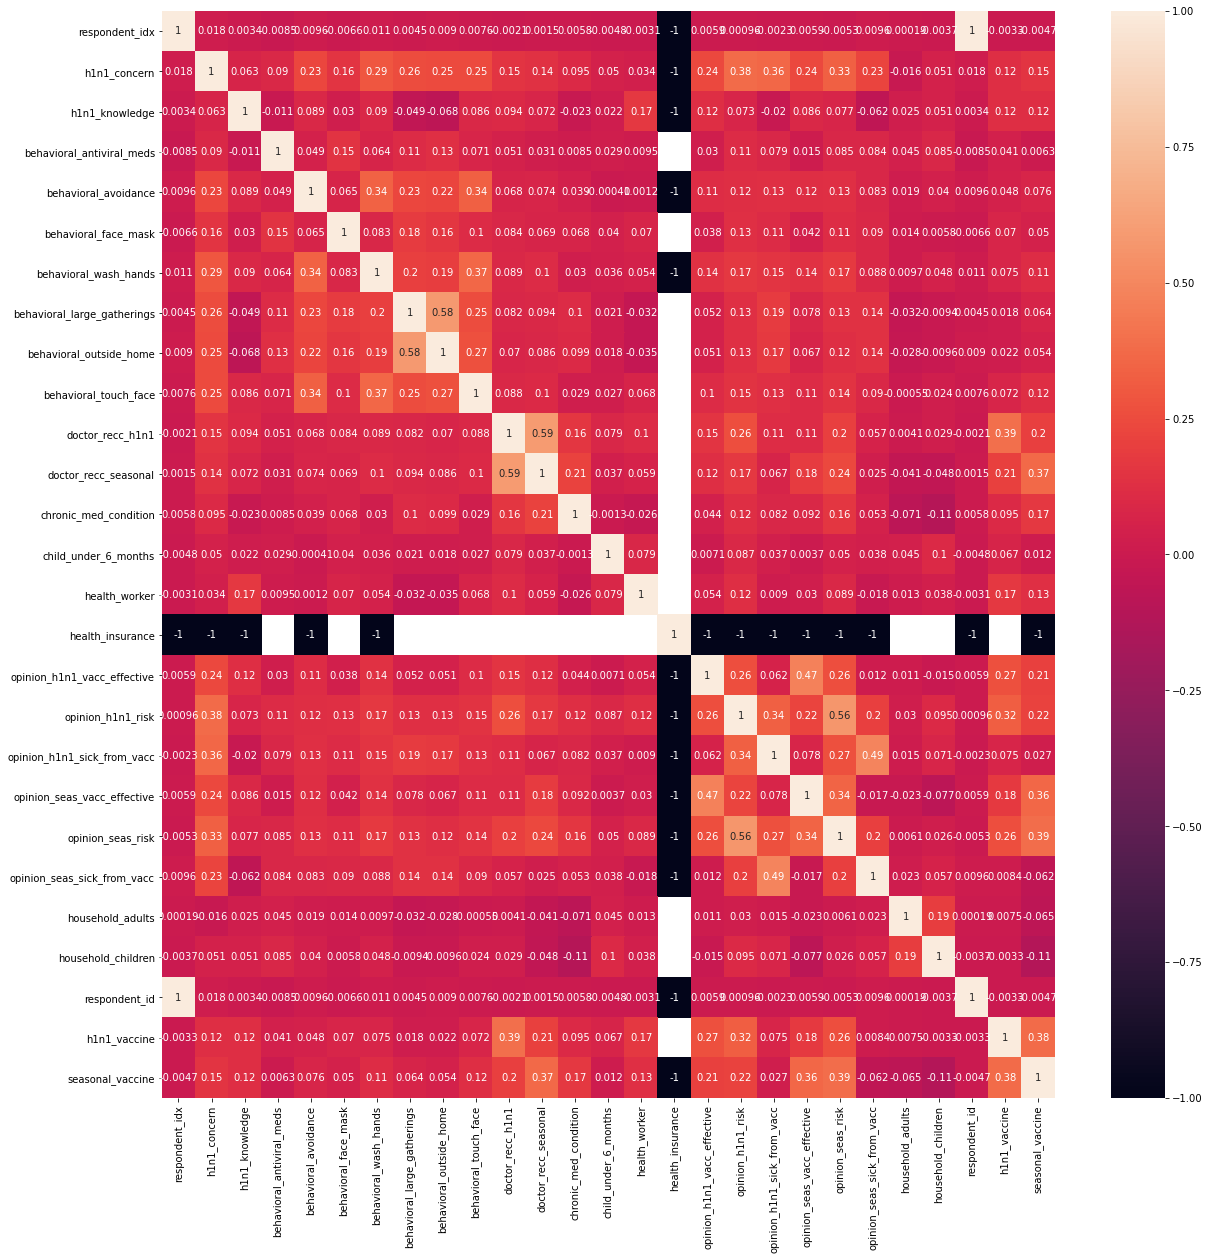

In [56]:
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(joined_df.corr(),annot=True,ax=ax);

This heatmap was meant to help us determine which features have the most correlation to the target (for feature selection) and find the features that were collinear with each other but its very hard to read so we inspected most of the categorical variables individually

In [ ]:
def vaccination_rate_plot(col, target, data, ax=None):
    """Stacked bar chart of vaccination rate for `target` against 
    `col`. 
    
    Args:
        col (string): column name of feature variable
        target (string): column name of target variable
        data (pandas DataFrame): dataframe that contains columns 
            `col` and `target`
        ax (matplotlib axes object, optional): matplotlib axes 
            object to attach plot to
    """
    counts = (joined_df[[target, col]]
                  .groupby([target, col])
                  .size()
                  .unstack(target)
             )
    group_counts = counts.sum(axis='columns')
    props = counts.div(group_counts, axis='index')

    props.plot(kind="barh", stacked=True, ax=ax)
    ax.invert_yaxis()
    ax.legend().remove()

This function will help plot a bar graph to illustrate the distribution of each class when filtering the data by each categorical column 

#### Education

In [57]:
tr_features['education'].value_counts()# can be ohe 

College Graduate    10097
Some College         7043
12 Years             5797
< 12 Years           2363
Name: education, dtype: int64

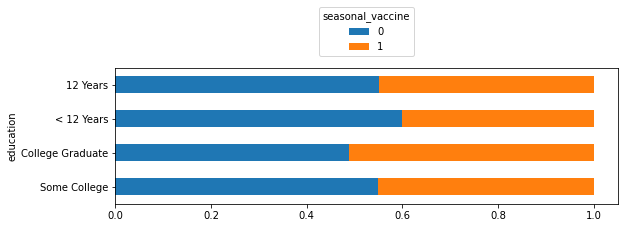

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(9, 2.5))
vaccination_rate_plot("education", 'seasonal_vaccine', joined_df, ax=ax)
ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), title='seasonal_vaccine');

In every category for this feature, the classes are pretty evenly distributed, which means it would be ok to leave this variable as is, to be processed in the pipeline

#### Race

In [59]:
tr_features['race'].value_counts()#can be ohe

White                21222
Black                 2118
Hispanic              1755
Other or Multiple     1612
Name: race, dtype: int64

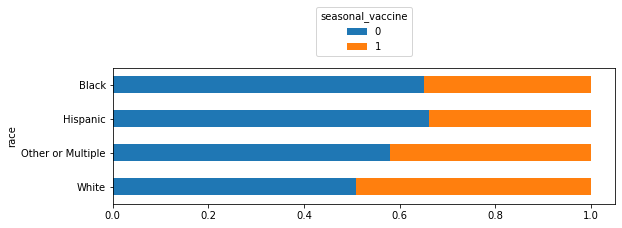

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(9, 2.5))
vaccination_rate_plot("race", 'seasonal_vaccine', joined_df, ax=ax)
ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), title='seasonal_vaccine');

A  discrepancy can be seen when we do a racial profile. Number of doses being administered to Minority groups are  comparatively much lower compared to White.

#### Marital Status

In [61]:
tr_features['marital_status'].value_counts()#maybe drop

Married        13555
Not Married    11744
Name: marital_status, dtype: int64

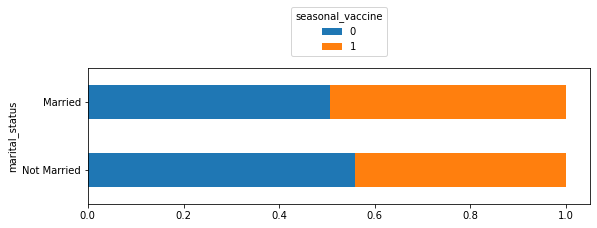

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(9, 2.5))
vaccination_rate_plot("marital_status", 'seasonal_vaccine', joined_df, ax=ax)
ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), title='seasonal_vaccine');

evenly distributed

#### Rent or Own 

In [63]:
tr_features['rent_or_own'].value_counts()

Own     18736
Rent     5929
Name: rent_or_own, dtype: int64

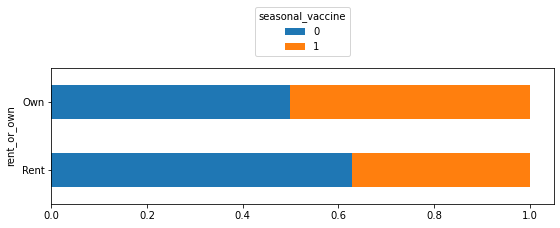

In [64]:
fig, ax = plt.subplots(1, 1, figsize=(9, 2.5))
vaccination_rate_plot("rent_or_own", 'seasonal_vaccine', joined_df, ax=ax)
ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), title='seasonal_vaccine');

#### Employment status

In [65]:
tr_features['employment_status'].value_counts()

Employed              13560
Not in Labor Force    10231
Unemployed             1453
Name: employment_status, dtype: int64

In [66]:
tr_features['employment_status']=tr_features['employment_status'].replace("Unemployed", "Not in Labor Force")
tr_features.loc[tr_features['employment_status'] == "Not in Labor Force", 'employment_industry'] = "Not in Labor Force"
tr_features.loc[tr_features['employment_status'] == "Not in Labor Force", 'employment_occupation'] = "Not in Labor Force"

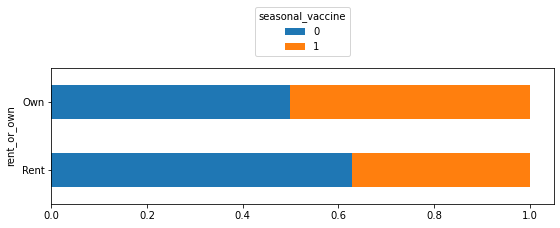

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(9, 2.5))
vaccination_rate_plot("rent_or_own", 'seasonal_vaccine', joined_df, ax=ax)
ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), title='seasonal_vaccine');

write something about what i did above

#### Geo/Region

In [68]:
tr_features['hhs_geo_region'].value_counts()

lzgpxyit    4297
fpwskwrf    3265
qufhixun    3102
oxchjgsf    2859
kbazzjca    2858
bhuqouqj    2846
mlyzmhmf    2243
lrircsnp    2078
atmpeygn    2033
dqpwygqj    1126
Name: hhs_geo_region, dtype: int64

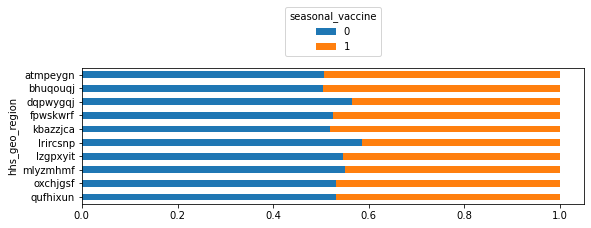

In [69]:
fig, ax = plt.subplots(1, 1, figsize=(9, 2.5))
vaccination_rate_plot("hhs_geo_region", 'seasonal_vaccine', joined_df, ax=ax)
ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), title='seasonal_vaccine');

#### Census

In [70]:
tr_features['census_msa'].value_counts()

MSA, Not Principle  City    11645
MSA, Principle City          7864
Non-MSA                      7198
Name: census_msa, dtype: int64

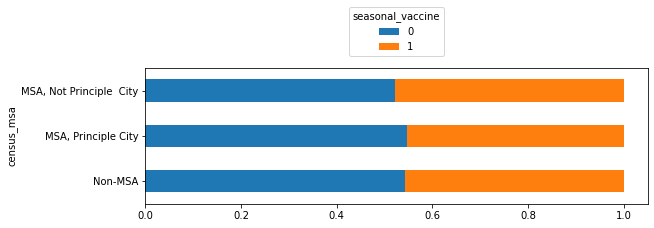

In [71]:
fig, ax = plt.subplots(1, 1, figsize=(9, 2.5))
vaccination_rate_plot("census_msa", 'seasonal_vaccine', joined_df, ax=ax)
ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), title='seasonal_vaccine');

#### Number of Children in Household

In [72]:
tr_features['household_children'].value_counts()

0.0    18672
1.0     3175
2.0     2864
3.0     1747
Name: household_children, dtype: int64

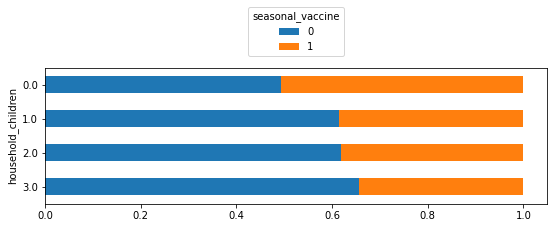

In [73]:
fig, ax = plt.subplots(1, 1, figsize=(9, 2.5))
vaccination_rate_plot("household_children", 'seasonal_vaccine', joined_df, ax=ax)
ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), title='seasonal_vaccine');

#### Number of Adults in the Household

In [74]:
tr_features['household_adults'].value_counts()

1.0    14474
0.0     8056
2.0     2803
3.0     1125
Name: household_adults, dtype: int64

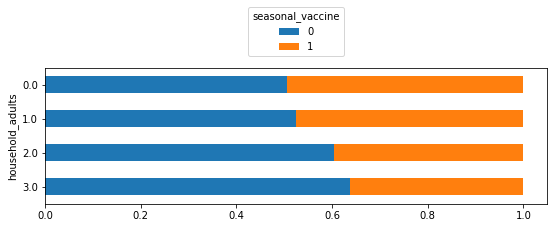

In [75]:
fig, ax = plt.subplots(1, 1, figsize=(9, 2.5))
vaccination_rate_plot("household_adults", 'seasonal_vaccine', joined_df, ax=ax)
ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), title='seasonal_vaccine');

#### Employment Industry

In [76]:
tr_features['employment_industry'].value_counts()#thinking about dropping 

Not in Labor Force    11684
fcxhlnwr               2468
wxleyezf               1804
ldnlellj               1231
pxcmvdjn               1037
atmlpfrs                926
arjwrbjb                871
xicduogh                851
mfikgejo                614
vjjrobsf                527
rucpziij                523
xqicxuve                511
saaquncn                338
cfqqtusy                325
nduyfdeo                286
mcubkhph                275
wlfvacwt                215
dotnnunm                201
haxffmxo                148
msuufmds                124
phxvnwax                 89
qnlwzans                 13
Name: employment_industry, dtype: int64

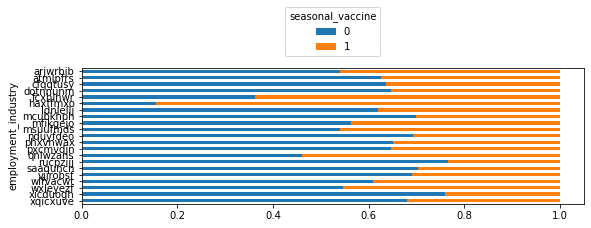

In [77]:
fig, ax = plt.subplots(1, 1, figsize=(9, 2.5))
vaccination_rate_plot("employment_industry", 'seasonal_vaccine', joined_df, ax=ax)
ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), title='seasonal_vaccine');

#### Employment Occupation

In [78]:
tr_features['employment_occupation'].value_counts()#thinking about dropping

Not in Labor Force    11684
xtkaffoo               1778
mxkfnird               1509
emcorrxb               1270
cmhcxjea               1247
xgwztkwe               1082
hfxkjkmi                766
qxajmpny                548
xqwwgdyp                485
kldqjyjy                469
uqqtjvyb                452
tfqavkke                388
ukymxvdu                372
vlluhbov                354
oijqvulv                344
ccgxvspp                341
bxpfxfdn                331
haliazsg                296
rcertsgn                276
xzmlyyjv                248
dlvbwzss                227
hodpvpew                208
dcjcmpih                148
pvmttkik                 98
Name: employment_occupation, dtype: int64

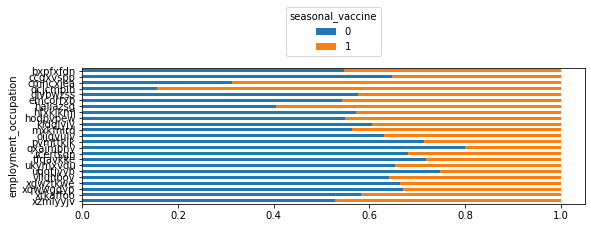

In [79]:
fig, ax = plt.subplots(1, 1, figsize=(9, 2.5))
vaccination_rate_plot("employment_occupation", 'seasonal_vaccine', joined_df, ax=ax)
ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), title='seasonal_vaccine');

##### Mapping Functions

the following mapping functions are used in categorical variable processing

In [ ]:
#column mapping function 
def col_value_mapper(col, mapping):
    return lambda df: df.assign(**{col:df[col].apply(mapping.get)})

In [81]:
#column mapping function 
def col_value_mapper(col, mapping):
    def update_df(df):
        return df.assign(**{col:df[col].apply(mapping.get)})
    return update_df

#### Age Group

In [82]:
tr_features['age_group'].value_counts()

65+ Years        6843
55 - 64 Years    5563
45 - 54 Years    5238
18 - 34 Years    5215
35 - 44 Years    3848
Name: age_group, dtype: int64

In [83]:
#age_group map and function wrapper
age_mean_map = {'18 - 34 Years': 26,
                '35 - 44 Years': 40,
                '45 - 54 Years': 50,
                '55 - 64 Years': 60,
                '65+ Years': 70, 
                }
age_group_transformer = FunctionTransformer(col_value_mapper("age_group", age_mean_map))

In [334]:
col_value_mapper("age_group", age_mean_map)(tr_features)['age_group']

0        60
1        40
2        26
3        70
4        50
         ..
26702    70
26703    26
26704    60
26705    26
26706    70
Name: age_group, Length: 26707, dtype: int64

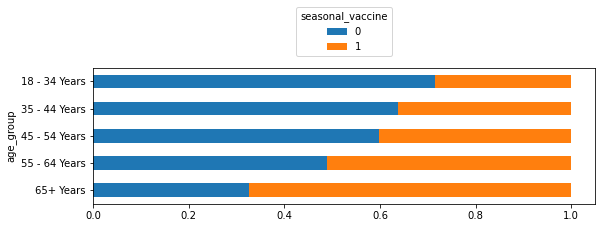

In [85]:
fig, ax = plt.subplots(1, 1, figsize=(9, 2.5))
vaccination_rate_plot("age_group", 'seasonal_vaccine', joined_df, ax=ax)
ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), title='seasonal_vaccine');

This variable needed to be treated differently than the others. As its category name is a range, it would not make sense to One hot encode this. Whats easier is to replace every value with the mean of the age group its in. However we cannot do this outside of a pipeline, as transforming this data outside of the pipeline will result in data leakage. So instead of transforming, we are using the mapping function above, wrapping a function transformer around and sticking it right into our pipeline. 

#### Income(Poverty)

In [86]:
tr_features['income_poverty'].value_counts()#needs a function

<= $75,000, Above Poverty    12777
> $75,000                     6810
Below Poverty                 2697
Name: income_poverty, dtype: int64

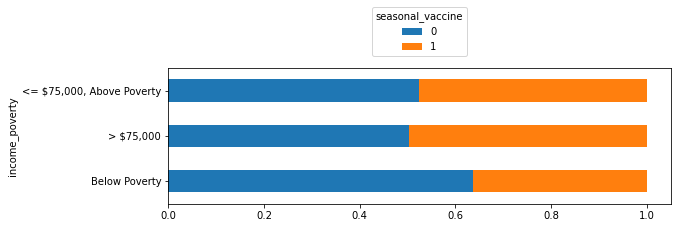

In [87]:
fig, ax = plt.subplots(1, 1, figsize=(9, 2.5))
vaccination_rate_plot("income_poverty", 'seasonal_vaccine', joined_df, ax=ax)
ax.legend(loc='lower center', bbox_to_anchor=(0.5, 1.05), title='seasonal_vaccine');


As you can see, there's a big discrepancy in the number of doses being administered in lower-income groups compared to the higher income groups. 

In [88]:
income_map = {'Below Poverty': 1,
              '<= $75,000, Above Poverty': 2,
              '> $75,000':3
             }
income_transformer = FunctionTransformer(col_value_mapper("income_poverty", income_map))

In [89]:
col_value_mapper("income_poverty", income_map)(tr_features)['income_poverty']

0        1.0
1        1.0
2        2.0
3        1.0
4        2.0
        ... 
26702    2.0
26703    2.0
26704    NaN
26705    2.0
26706    2.0
Name: income_poverty, Length: 26707, dtype: float64

### Train-Test Split

In [90]:
tr_features.columns

Index(['respondent_id', 'h1n1_concern', 'h1n1_knowledge',
       'behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
       'education', 'race', 'sex', 'income_poverty', 'marital_status',
       'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa',
       'household_adults', 'household_children', 'employment_industry',
       'employment_occupation'],
      dtype='object')

In [91]:
#defining X and y
X=tr_features.drop(['h1n1_concern','h1n1_knowledge',
                'doctor_recc_h1n1','opinion_h1n1_vacc_effective',
                    'opinion_h1n1_risk','opinion_h1n1_sick_from_vacc'],axis=1)
y=tr_labels['seasonal_vaccine']

In [329]:
X_train, X_test, y_train, y_test = train_test_split(
    tr_features,
    tr_labels['seasonal_vaccine'],
    test_size=0.33,
    shuffle=True,
    stratify=tr_labels['seasonal_vaccine']
)

We performed a train test split because we needed to validate out model while mitigating any data leakages. in this case the testing data also acts as our hold out set.

### Dummy Classifier

In [104]:
from model_with_cv import ModelWithAOCROC

The scoring metric we are going to be using for all models in this notebook is a class with the inherited methods of ModelWithCV demonstrated in lecture (ref). ModelWithAUCROC is exactly the same class but with the added method of plt_roc_curve which plots the AUC/ROC curve. The Receiver Operating Characteristic (ROC) curve plots the true-positive rate (the rate at which the model guessed positive (vaccinated in this case) and it actually was positive) vs. the false-positive rate (the rate at which the model guessed positive but was wrong. The Area Under the Curve (AUC) gives us a score we can use evaluate models performance and finally pick our last model to use in validation

In [103]:
dummy = DummyClassifier()
dummy.fit(X_train,y_train)

DummyClassifier()

The dummy Classifier acts as our baseline model to compare the scores to other models to see improvement

In [105]:
dummy_scoring = ModelWithAOCROC(dummy,'dummy',X_train,y_train)

In [106]:
dummy_scoring.print_cv_summary()

CV Results for `dummy` model:
            0.53440 ± 0.00015 accuracy
        


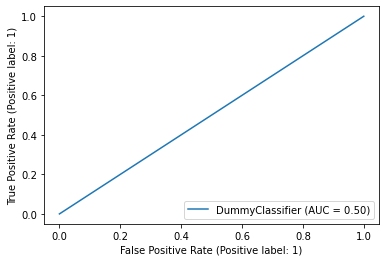

In [107]:
dummy_scoring.plt_roc_curve()

with an AUC score of 0.50 we can deem the baseline model as being accurately able to predict the correct class correctly 50% of the time

## Iterative Model Process

### Pre-processing Piple #1

In [278]:
num_cols = tr_features.columns[tr_features.dtypes != 'object'].values
cat_cols = tr_features.columns[tr_features.dtypes == 'object'].values

In [279]:
seperate_processing_cols = ["age_group", "income_poverty"]

high_missing_cols = []
cat_cols = [x for x in cat_cols if (x not in high_missing_cols and x not in seperate_processing_cols)]
num_cols = [x for x in num_cols if (x not in high_missing_cols and x not in seperate_processing_cols)]
num_to_cat_preprocessing = Pipeline(steps=[
    ('age_group_trasnformer',age_group_transformer),
    ('income_transformer',income_transformer),
    ('standard_scaler', StandardScaler()),
    ('simple_imputer', SimpleImputer(strategy = 'mean'))
])

numeric_preprocessing = Pipeline(steps=[
    ('standard_scaler', StandardScaler()),
    ('imputer', SimpleImputer(strategy='mean'))])

catergoric_preprocessing = Pipeline(steps=[
     ('simple_imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('one_hot_encoder', OneHotEncoder())
])


total_preprocessing = ColumnTransformer(
    transformers = [('num_to_cat_preprocessing',num_to_cat_preprocessing,seperate_processing_cols),
        ('numeric', numeric_preprocessing, num_cols),
        ('categoric',catergoric_preprocessing , cat_cols)  
    ],
    remainder = "drop"
)

write something about this 

### Classification Models

#### Logistic Regression

It is a predictive algorithm using independent variables to predict the dependent variable, just like Linear Regression, but with a difference that the dependent variable should be categorical variable.
Independent variables can be numeric or categorical variables, but the dependent variable will always be categorical. Logistic regression is a statistical model that uses Logistic function to model the conditional probability. For binary regression, we calculate the conditional probability of the dependent variable Y, given independent variable X.

In [102]:
selector = RFE(LogisticRegression(max_iter=1000), n_features_to_select=5, step=1)

log_reg_pipe=Pipeline([('total_preprocessing',total_preprocessing),
                     ('rfe_logreg',selector)])

In [96]:
log_reg_pipe.fit(X_train,y_train);

Pipeline(steps=[('total_preprocessing',
                 ColumnTransformer(transformers=[('num_to_cat_preprocessing',
                                                  Pipeline(steps=[('age_group_trasnformer',
                                                                   FunctionTransformer(func=<function col_value_mapper.<locals>.update_df at 0x7f94fc1328b0>)),
                                                                  ('income_transformer',
                                                                   FunctionTransformer(func=<function col_value_mapper.<locals>.update_df at 0x7f94f9f6cc10>)),
                                                                  ('standard...
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
         

In [98]:
logreg_scoring=ModelWithAOCROC(log_reg_pipe, 'logreg', X_train, y_train, cv_now=False)

In [99]:
logreg_scoring.cross_validate(kfolds=3)

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:985: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:990: RuntimeWarning: invalid value encountered in true_divide
  T = new_sum / new_sample_count
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:1020: RuntimeWarning: invalid value encountered in true_divide
  new_unnormalized_variance -= correction ** 2 / new_sample_count
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:81: RuntimeWarning: invalid value encountered in less_equal
  return var <= upper_bound


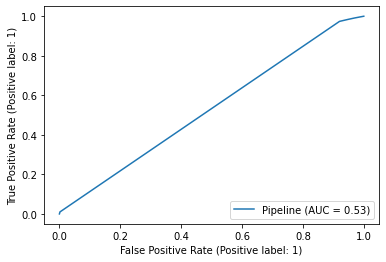

In [100]:
logreg_scoring.plt_roc_curve()

The higher the AUC, the better the performance of the model at distinguishing between the positive and negative classes. So this model is only slightly better than the baseline

#### K Nearest Neighbors

The KNN algorithm assumes that similar things exist in proximity. In other words, similar things are near to each other. It calculates the distance of the 5 nearest neighbors and classifies based on different metrics, but the default is “most frequent”. KNN’s main disadvantage of becoming significantly slower as the volume of data increases makes it an impractical choice in environments where predictions need to be made rapidly. However it is easy to implement as it requires no fitting or training.

In [165]:
knn_pipe= Pipeline([('total_preprocessing',total_preprocessing),
                     ('knn',KNeighborsClassifier(n_neighbors=3))])

In [167]:
knn_pipe.fit(X_train,y_train);

In [169]:
knn_scoring=ModelWithAOCROC(knn_pipe, 'knn_pipe', X_train, y_train, cv_now=True)

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:985: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:990: RuntimeWarning: invalid value encountered in true_divide
  T = new_sum / new_sample_count
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:1020: RuntimeWarning: invalid value encountered in true_divide
  new_unnormalized_variance -= correction ** 2 / new_sample_count
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:81: RuntimeWarning: invalid value encountered in less_equal
  return var <= upper_bound


In [171]:
knn_scoring.print_cv_summary()

CV Results for `knn_pipe` model:
            0.70419 ± 0.00988 accuracy
        


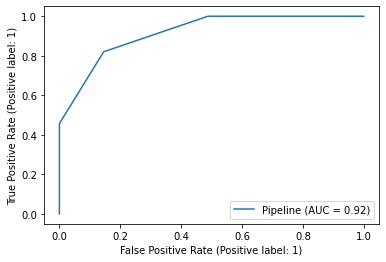

In [174]:
knn_scoring.plt_roc_curve()

This model has a very high AUC score, which would normally be exciting, but an AUC over 0.9 and you risk choosing an algorithm that is over-fitting to your data, which results in a model that is over fit too.

#### Decision Tree Classifier

The decision tree is a "white-box" type of Machine Learning algorithm. It shares internal decision-making logic, which is not available in the black-box type of algorithms such as Neural Network. Its training time is faster compared to other algorithms such as neural networks. The decision tree is a non-parametric method, which does not depend upon probability distribution assumptions. Decision trees can handle high-dimensional data with good accuracy. However it is sensitive to noisy data and is prone to over-fitting, it also has trouble with imbalanced data sets.

In [176]:
dt_pipe= Pipeline([('total_preprocessing',total_preprocessing),
                     ('dt',DecisionTreeClassifier(random_state=42))])

In [178]:
dt_pipe.fit(X_train,y_train);

In [180]:
dtc_scoring = ModelWithAOCROC(dt_pipe, 'dt_pipe', X_train, y_train, cv_now=True);

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:985: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:990: RuntimeWarning: invalid value encountered in true_divide
  T = new_sum / new_sample_count
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:1020: RuntimeWarning: invalid value encountered in true_divide
  new_unnormalized_variance -= correction ** 2 / new_sample_count
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:81: RuntimeWarning: invalid value encountered in less_equal
  return var <= upper_bound


In [182]:
dtc_scoring.print_cv_summary()

CV Results for `dt_pipe` model:
            0.68278 ± 0.01219 accuracy
        


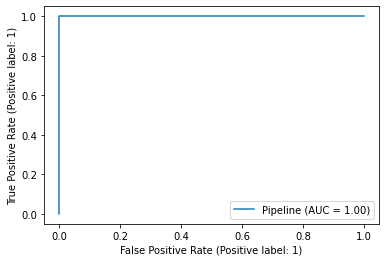

In [183]:
dtc_scoring.plt_roc_curve()

The scenario where the AUC is equal exactly to 1 is highly improbable and is very much indicate of an over- fit model

### Ensemble Model Building


#### Random Tree Classifier

In [228]:
rfc_pipe=Pipeline([('total_preprocessing',total_preprocessing),
                     ('rfc',RandomForestClassifier(random_state=42))])

In [229]:
rfc_pipe.fit(X_train,y_train);

In [230]:
rfc_scoring=ModelWithAOCROC(rfc_pipe, 'rfc_pipe', X_train, y_train, cv_now=True)

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:985: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:990: RuntimeWarning: invalid value encountered in true_divide
  T = new_sum / new_sample_count
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:1020: RuntimeWarning: invalid value encountered in true_divide
  new_unnormalized_variance -= correction ** 2 / new_sample_count
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:81: RuntimeWarning: invalid value encountered in less_equal
  return var <= upper_bound


In [231]:
rfc_scoring.print_cv_summary()

CV Results for `rfc_pipe` model:
            0.77986 ± 0.00509 accuracy
        


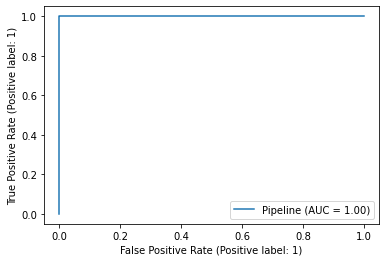

In [232]:
rfc_scoring.plt_roc_curve()

This model, like the DTC is over fit too

#### Extra Trees Classifier

Sometimes we might want even one more bit of randomization. Instead of always choosing the *optimal* branching path, we might just choose a branching path at random. If we're doing that, then we've got extremely randomized trees.

There are now **three** levels of randomization: sampling of data, sampling of features, and random selection of branching paths.


etc = ExtraTreesClassifier(max_features='sqrt', max_samples=.5, bootstrap=True, random_state=42)
etc_pipe= Pipeline([('total_preprocessing',total_preprocessing), ('etc', etc)])

In [115]:
etc_pipe.fit(X_train,y_train);

Pipeline(steps=[('total_preprocessing',
                 ColumnTransformer(transformers=[('num_to_cat_preprocessing',
                                                  Pipeline(steps=[('age_group_trasnformer',
                                                                   FunctionTransformer(func=<function col_value_mapper.<locals>.update_df at 0x7f94fc1328b0>)),
                                                                  ('income_transformer',
                                                                   FunctionTransformer(func=<function col_value_mapper.<locals>.update_df at 0x7f94f9f6cc10>)),
                                                                  ('standard...
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('one_hot_encoder',
        

In [116]:
etc_scoring=ModelWithAOCROC(etc_pipe, 'etc_pipe', X_train, y_train, cv_now=True)

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:985: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:990: RuntimeWarning: invalid value encountered in true_divide
  T = new_sum / new_sample_count
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:1020: RuntimeWarning: invalid value encountered in true_divide
  new_unnormalized_variance -= correction ** 2 / new_sample_count
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:81: RuntimeWarning: invalid value encountered in less_equal
  return var <= upper_bound


In [118]:
etc_scoring.print_cv_summary()

CV Results for `etc_pipe` model:
            0.77544 ± 0.00970 accuracy
        


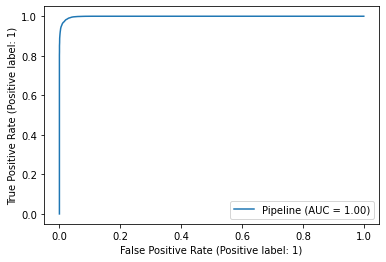

In [119]:
etc_scoring.plt_roc_curve()

#### Voting Classifier

Averages the scores of the algorithms that are defined within its instantiation., no AUC score so decided not to go further had it been different would have played around the weighting of importance in terms of results for each model hoping to improve my score. But without a proper way of getting the AUC score, another metric would have to be used on all the other models as well. This is why i didn't go down this route.

In [233]:
vc = VotingClassifier(estimators=[
    ('logreg', LogisticRegression(max_iter=1000)),
    ('knn', KNeighborsClassifier(n_neighbors=3)),
    ('dt', DecisionTreeClassifier(random_state=42))
])

In [234]:
vc_pipe=Pipeline([('total_preprocessing',total_preprocessing), ('vc',vc)])

In [235]:
vc_pipe.fit(X_train,y_train);

In [236]:
#instantiating scoring function 
vc_scoring=ModelWithAOCROC(vc_pipe, 'vc_pipe', X_train, y_train, cv_now=True)

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:985: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:990: RuntimeWarning: invalid value encountered in true_divide
  T = new_sum / new_sample_count
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:1020: RuntimeWarning: invalid value encountered in true_divide
  new_unnormalized_variance -= correction ** 2 / new_sample_count
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:81: RuntimeWarning: invalid value encountered in less_equal
  return var <= upper_bound


In [237]:
vc_scoring.print_cv_summary()

CV Results for `vc_pipe` model:
            0.75801 ± 0.00775 accuracy
        


#### Bagging

Bagging is an ensemble model that involves a combination of bootstrapping and aggregating. This algorithm will take a sample of your training data and fit a decision tree classifier onto it. It will repeat this with different batches of data and repeat the whole process, an example of bootstrapping. When the maximum desired tree number is reached, a holistic prediction is reached by using all the predictions on all the trees that have been fitted, an example of aggregating. 

Since we are bootstrapping and aggregating in the one algorithm, we're bagging.  As with other tree classifiers this algorithm is prone to over-fitting the data, however the aggregation may reduce variance.  By averaging out quirks that individual trees might have learned, thus smoothing over different ways of over-fitting


In [184]:
bag_pipe=Pipeline([('total_preprocessing',total_preprocessing), ('bag',BaggingClassifier())])

In [185]:
bag_pipe.fit(X_train,y_train);

In [186]:
bag_scoring=ModelWithAOCROC(bag_pipe, 'bag_pipe', X_train, y_train, cv_now=True)

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:985: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:990: RuntimeWarning: invalid value encountered in true_divide
  T = new_sum / new_sample_count
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:1020: RuntimeWarning: invalid value encountered in true_divide
  new_unnormalized_variance -= correction ** 2 / new_sample_count
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:81: RuntimeWarning: invalid value encountered in less_equal
  return var <= upper_bound


In [187]:
bag_scoring.print_cv_summary()

CV Results for `bag_pipe` model:
            0.75208 ± 0.00867 accuracy
        


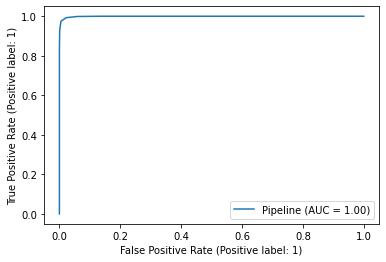

In [188]:
bag_scoring.plt_roc_curve()

#### Gradient Boosting Classifier

Gradient boosting trees solves part of the limitation mentioned above. Instead of training a single tree, multiple trees are trained sequentially. To lower the variance of the trees, they are however restricted. They are turned into weak learners by setting limits on the depth of the trees. The decision trees depth if often chosen between 3 and 6 layers.

In [189]:
gbc_pipe = Pipeline([('total_preprocessing',total_preprocessing), ('gbc', GradientBoostingClassifier(random_state=42))])

In [190]:
gbc_pipe.fit(X_train,y_train);

In [191]:
gbc_scoring=ModelWithAOCROC(gbc_pipe, 'gbc_pipe', X_train, y_train, cv_now=True)

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:985: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:990: RuntimeWarning: invalid value encountered in true_divide
  T = new_sum / new_sample_count
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:1020: RuntimeWarning: invalid value encountered in true_divide
  new_unnormalized_variance -= correction ** 2 / new_sample_count
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:81: RuntimeWarning: invalid value encountered in less_equal
  return var <= upper_bound


In [192]:
gbc_scoring.print_cv_summary()

CV Results for `gbc_pipe` model:
            0.78612 ± 0.00769 accuracy
        


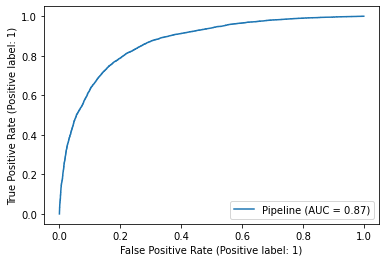

In [193]:
gbc_scoring.plt_roc_curve()

This is a AUC that is ideal, as it is between 0.8 - 0.9. which is a good as it is still relatively high, which means this model has high accuracy but also low enough where over-fitting isn't as much of an issue. This makes sense as GBC is an algorithm that works hard to reduce the variance in the model

#### XG Boost

XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework. XGBoost provides a parallel tree boosting (also known as GBDT, GBM) that solve many data science problems in a fast and accurate way. The same code runs on major distributed environment (Hadoop, SGE, MPI) and can solve problems beyond billions of examples.

In [194]:
xgc = XGBClassifier(random_state=42, objective='binary:logistic')

In [195]:
xgc_pipe=Pipeline([('total_preprocessing',total_preprocessing), ('xgc',xgc)])

In [196]:
xgc_pipe.fit(X_train,y_train);

In [197]:
xgc_scoring=ModelWithAOCROC(xgc_pipe, 'xcg_pipe', X_train, y_train, cv_now=True)

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:985: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:990: RuntimeWarning: invalid value encountered in true_divide
  T = new_sum / new_sample_count
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:1020: RuntimeWarning: invalid value encountered in true_divide
  new_unnormalized_variance -= correction ** 2 / new_sample_count
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:81: RuntimeWarning: invalid value encountered in less_equal
  return var <= upper_bound


In [198]:
xgc_scoring.print_cv_summary()

CV Results for `xcg_pipe` model:
            0.77645 ± 0.00596 accuracy
        


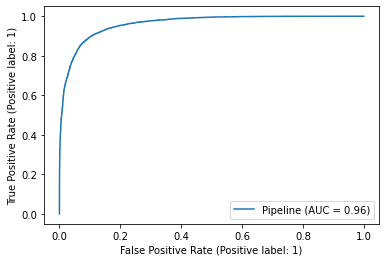

In [199]:
xgc_scoring.plt_roc_curve()

I was expecting this score to be much more promising! but this score indicates a model dangerously close to a perfect 1 (over-fit to the max).

#### Stacking Classifier

First, we ask several different models to make predictions about the target Rather than taking a simple average or vote to determine the outcome, feed these results into a final model that makes the prediction based on the other models’ predictions. In this case we are using the results of our logistic regression as input into our Gradient Boosting Classifier. 

In [200]:
stc = StackingClassifier(estimators=[  ('log_reg', LogisticRegression(max_iter=1000)),
    ('gbc', GradientBoostingClassifier(random_state=42)),
  
    
])
stc_pipe= Pipeline([('total_preprocessing',total_preprocessing), ('stc', stc)])

In [201]:
stc_pipe.fit(X_train,y_train);

In [202]:
stc_scoring=ModelWithAOCROC(stc_pipe, 'stc_pipe', X_train, y_train, cv_now=True)

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:985: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:990: RuntimeWarning: invalid value encountered in true_divide
  T = new_sum / new_sample_count
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:1020: RuntimeWarning: invalid value encountered in true_divide
  new_unnormalized_variance -= correction ** 2 / new_sample_count
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:81: RuntimeWarning: invalid value encountered in less_equal
  return var <= upper_bound


In [203]:
stc_scoring.print_cv_summary()

CV Results for `stc_pipe` model:
            0.78668 ± 0.00765 accuracy
        


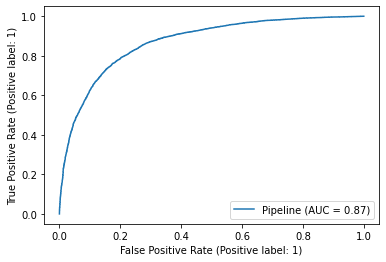

In [204]:
stc_scoring.plt_roc_curve()

This score is no different to the score that GBC has by it self. 

#### Stacking Classifier 2

In this stacking model we use the  results of our logistic regression with RFE named ‘selector’ as input into our XG Boosting Classifier. 

In [286]:
stc2 = StackingClassifier(estimators=[ (('rfe_logreg',selector)),
    ('xgc',  XGBClassifier(random_state=42, objective='binary:logistic')),
   
    
])
stc2_pipe= Pipeline([('total_preprocessing',total_preprocessing), ('stc2', stc2)])

In [287]:
stc2_pipe.fit(X_train,y_train);

In [293]:
stc2_scoring=ModelWithAOCROC(stc2_pipe, 'stc2_pipe', X_train, y_train, cv_now=False)

In [294]:
stc2_scoring.cross_validate(kfolds=3)

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:985: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:990: RuntimeWarning: invalid value encountered in true_divide
  T = new_sum / new_sample_count
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:1020: RuntimeWarning: invalid value encountered in true_divide
  new_unnormalized_variance -= correction ** 2 / new_sample_count
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:81: RuntimeWarning: invalid value encountered in less_equal
  return var <= upper_bound


In [295]:
stc2_scoring.print_cv_summary()

CV Results for `stc2_pipe` model:
            0.77198 ± 0.00274 accuracy
        


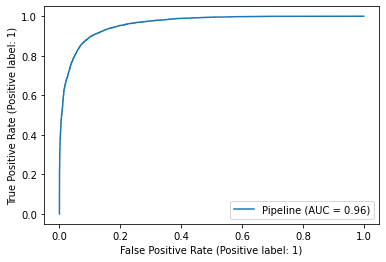

In [296]:
stc2_scoring.plt_roc_curve()

This score is the same as what XG boost had on its own.

### Pre-Pocessing Pipe #1 Results Table

| Model Name      | AOC |
| -----------  | ----------- |
| Dummy Class  |0.50         |
| Log_Reg      |0.53         |
| KNN          |0.92         |
| Decision T   |1.00         |
|  RTC         |1.00         |
| Extra Trees  |1.00         |
| Bagging      |1.00         |
|GradientBoost |0.87         |
| XG Boost     |0.96         |
|GBC& LoR Stack|0.87         |
|XG & LoR Stack|0.96         |


Out of all the algorithms, the most promising is Gradient Boosting or the stacking with gradient boosting.

### Pre-processing Pipe #2

We wanted to rerun these models with a different Column transformer. The code below maps both age group and income in one map and thus only one function is wrapped and put in the transformer. This whole workflow is the same as the workflow from Pre-preprocessing Pipe #1. Therefore i have only commented if the values were different

In [297]:
seperate_processing_cols = ["age_group", "income_poverty"]
full_map = {"age_group":age_mean_map,
            "income_poverty":income_map}
def map_to_numeric(x, mapping):
    if mapping.get(x) == None:
        return nan
    else:
        return mapping.get(x)

def num_to_cat(df):
    new_df = copy.deepcopy(df)
    for col in seperate_processing_cols:
        new_df[col] = df[col].apply(lambda x: map_to_numeric(x, full_map.get(col))) 
    return new_df

num_to_cat_transformer = FunctionTransformer(num_to_cat) 

In [298]:
high_missing_cols = []
cat_cols = [x for x in cat_cols if (x not in high_missing_cols and x not in seperate_processing_cols)]
num_cols = [x for x in num_cols if (x not in high_missing_cols and x not in seperate_processing_cols)]
# chain preprocessing into a Pipeline object
# each step is a tuple of (name you chose, sklearn transformer)
num_to_cat_preprocessing_steps = Pipeline([
    ('num_to_cat', num_to_cat_transformer),
    ('simple_imputer', SimpleImputer(strategy='mean')),
    ('standard_scaler', StandardScaler()),
    ])

numeric_preprocessing_steps = Pipeline(steps=[
    ('standard_scaler', StandardScaler()),
    ('imputer', SimpleImputer(strategy='mean'))])
categoric_preprocessing_steps = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])
# create the preprocessor stage of final pipeline
# each entry in the transformer list is a tuple of
# (name you choose, sklearn transformer, list of columns)
total_preprocessing= ColumnTransformer(
    transformers = [
        ("numeric", numeric_preprocessing_steps, num_cols),
        ("non_numeric",categoric_preprocessing_steps,cat_cols),
        ("nume_to_cat", num_to_cat_preprocessing_steps, seperate_processing_cols)
    ],
    remainder = "drop"
)

### Classification Models

#### Logistic Regression

In [213]:
selector = RFE(LogisticRegression(max_iter=1000), n_features_to_select=5, step=1)

log_reg_pipe=Pipeline([('total_preprocessing',total_preprocessing),
                     ('rfe_logreg',selector)])


In [215]:
log_reg_pipe.fit(X_train,y_train);

In [216]:
logreg_scoring=ModelWithAOCROC(log_reg_pipe, 'logreg', X_train, y_train, cv_now=False)

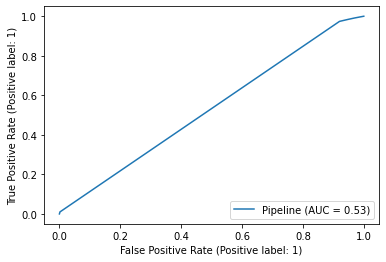

In [217]:
logreg_scoring.plt_roc_curve()

#### K-Nearest-Neighbours

In [218]:
knn_pipe= Pipeline([('total_preprocessing',total_preprocessing),
                     ('knn',KNeighborsClassifier(n_neighbors=3))])

In [219]:
knn_pipe.fit(X_train,y_train);

In [220]:
knn_scoring=ModelWithAOCROC(knn_pipe, 'knn_pipe', X_train, y_train, cv_now=True)

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:985: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:990: RuntimeWarning: invalid value encountered in true_divide
  T = new_sum / new_sample_count
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:1020: RuntimeWarning: invalid value encountered in true_divide
  new_unnormalized_variance -= correction ** 2 / new_sample_count
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:81: RuntimeWarning: invalid value encountered in less_equal
  return var <= upper_bound


In [221]:
knn_scoring.print_cv_summary()

CV Results for `knn_pipe` model:
            0.70318 ± 0.01063 accuracy
        


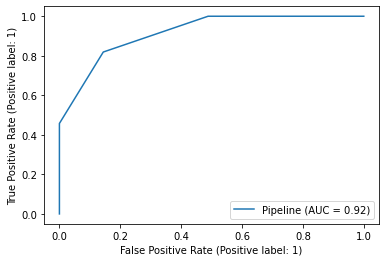

In [222]:
knn_scoring.plt_roc_curve()

#### Decision Tree

In [223]:
dt_pipe= Pipeline([('total_preprocessing',total_preprocessing),
                     ('dt',DecisionTreeClassifier(random_state=42))])

In [224]:
dt_pipe.fit(X_train,y_train);

In [225]:
dtc_scoring = ModelWithAOCROC(dt_pipe, 'dt_pipe', X_train, y_train, cv_now=True);

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:985: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:990: RuntimeWarning: invalid value encountered in true_divide
  T = new_sum / new_sample_count
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:1020: RuntimeWarning: invalid value encountered in true_divide
  new_unnormalized_variance -= correction ** 2 / new_sample_count
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:81: RuntimeWarning: invalid value encountered in less_equal
  return var <= upper_bound


In [226]:
dtc_scoring.print_cv_summary()

CV Results for `dt_pipe` model:
            0.68010 ± 0.01114 accuracy
        


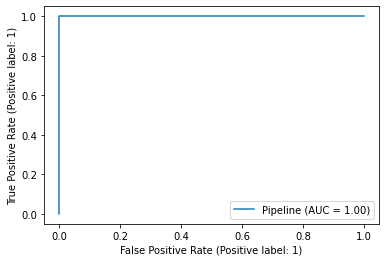

In [227]:
dtc_scoring.plt_roc_curve()

### Ensemble Model Building

#### Random Tree Classifier

In [241]:
rfc_pipe=Pipeline([('total_preprocessing',total_preprocessing),
                     ('rfc',RandomForestClassifier(random_state=42))])

In [242]:
rfc_pipe.fit(X_train,y_train);

In [243]:
rfc_scoring=ModelWithAOCROC(rfc_pipe, 'rfc_pipe', X_train, y_train, cv_now=True)

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:985: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:990: RuntimeWarning: invalid value encountered in true_divide
  T = new_sum / new_sample_count
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:1020: RuntimeWarning: invalid value encountered in true_divide
  new_unnormalized_variance -= correction ** 2 / new_sample_count
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:81: RuntimeWarning: invalid value encountered in less_equal
  return var <= upper_bound


In [244]:
rfc_scoring.print_cv_summary()

CV Results for `rfc_pipe` model:
            0.77986 ± 0.00509 accuracy
        


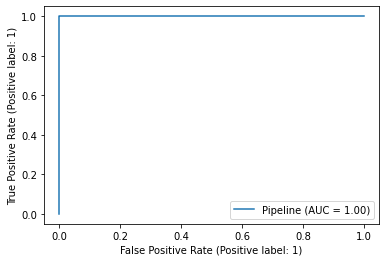

In [245]:
rfc_scoring.plt_roc_curve()

#### Extra Trees Classifier

In [247]:
etc = ExtraTreesClassifier(max_features='sqrt', max_samples=.5, bootstrap=True, random_state=42)
etc_pipe= Pipeline([('total_preprocessing',total_preprocessing), ('etc', etc)])

In [248]:
etc_pipe.fit(X_train,y_train);

In [249]:
etc_scoring=ModelWithAOCROC(etc_pipe, 'etc_pipe', X_train, y_train, cv_now=True)

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:985: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:990: RuntimeWarning: invalid value encountered in true_divide
  T = new_sum / new_sample_count
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:1020: RuntimeWarning: invalid value encountered in true_divide
  new_unnormalized_variance -= correction ** 2 / new_sample_count
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:81: RuntimeWarning: invalid value encountered in less_equal
  return var <= upper_bound


In [250]:
etc_scoring.print_cv_summary()

CV Results for `etc_pipe` model:
            0.77399 ± 0.00760 accuracy
        


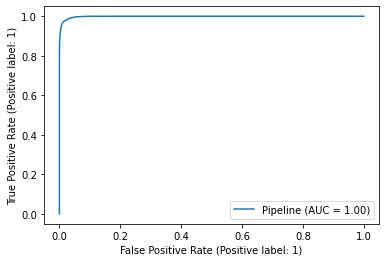

In [251]:
etc_scoring.plt_roc_curve()

#### Voting Classifier

In [253]:
vc = VotingClassifier(estimators=[
    ('logreg', LogisticRegression(max_iter=1000)),
    ('knn', KNeighborsClassifier(n_neighbors=3)),
    ('dt', DecisionTreeClassifier(random_state=42))
])

In [254]:
vc_pipe=Pipeline([('total_preprocessing',total_preprocessing), ('vc',vc)])

In [255]:
vc_pipe.fit(X_train,y_train);

In [256]:
vc_scoring=ModelWithAOCROC(vc_pipe, 'vc_pipe', X_train, y_train, cv_now=True)

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:985: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:990: RuntimeWarning: invalid value encountered in true_divide
  T = new_sum / new_sample_count
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:1020: RuntimeWarning: invalid value encountered in true_divide
  new_unnormalized_variance -= correction ** 2 / new_sample_count
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:81: RuntimeWarning: invalid value encountered in less_equal
  return var <= upper_bound


In [257]:
vc_scoring.print_cv_summary()

CV Results for `vc_pipe` model:
            0.75801 ± 0.00775 accuracy
        


#### Bagging

In [258]:
bag_pipe=Pipeline([('total_preprocessing',total_preprocessing), ('bag',BaggingClassifier())])

In [259]:
bag_pipe.fit(X_train,y_train);

In [260]:
bag_scoring=ModelWithAOCROC(bag_pipe, 'bag_pipe', X_train, y_train, cv_now=True)

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:985: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:990: RuntimeWarning: invalid value encountered in true_divide
  T = new_sum / new_sample_count
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:1020: RuntimeWarning: invalid value encountered in true_divide
  new_unnormalized_variance -= correction ** 2 / new_sample_count
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:81: RuntimeWarning: invalid value encountered in less_equal
  return var <= upper_bound


In [261]:
bag_scoring.print_cv_summary()

CV Results for `bag_pipe` model:
            0.75566 ± 0.00739 accuracy
        


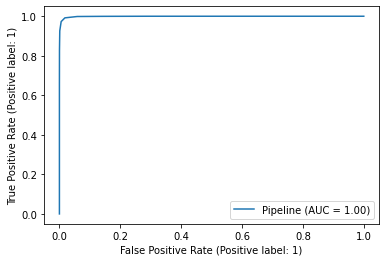

In [262]:
bag_scoring.plt_roc_curve()

#### Gradient Boosting Classifier

In [263]:
gbc_pipe = Pipeline([('total_preprocessing',total_preprocessing), ('gbc', GradientBoostingClassifier(random_state=42))])

In [264]:
gbc_pipe.fit(X_train,y_train);

In [265]:
gbc_scoring=ModelWithAOCROC(gbc_pipe, 'gbc_pipe', X_train, y_train, cv_now=True)

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:985: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:990: RuntimeWarning: invalid value encountered in true_divide
  T = new_sum / new_sample_count
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:1020: RuntimeWarning: invalid value encountered in true_divide
  new_unnormalized_variance -= correction ** 2 / new_sample_count
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:81: RuntimeWarning: invalid value encountered in less_equal
  return var <= upper_bound


In [266]:
gbc_scoring.print_cv_summary()

CV Results for `gbc_pipe` model:
            0.78612 ± 0.00769 accuracy
        


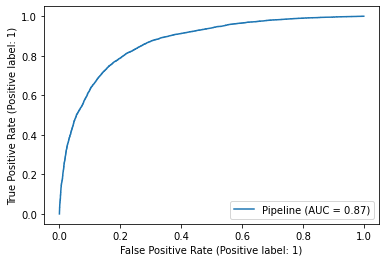

In [267]:
gbc_scoring.plt_roc_curve()

#### XG Boost

In [269]:
xgc = XGBClassifier(random_state=42, objective='binary:logistic')

In [270]:
xgc_pipe=Pipeline([('total_preprocessing',total_preprocessing), ('xgc',xgc)])

In [271]:
xgc_pipe.fit(X_train,y_train);

In [272]:
xgc_scoring=ModelWithAOCROC(xgc_pipe, 'xcg_pipe', X_train, y_train, cv_now=True)

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:985: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:990: RuntimeWarning: invalid value encountered in true_divide
  T = new_sum / new_sample_count
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:1020: RuntimeWarning: invalid value encountered in true_divide
  new_unnormalized_variance -= correction ** 2 / new_sample_count
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:81: RuntimeWarning: invalid value encountered in less_equal
  return var <= upper_bound


In [273]:
xgc_scoring.print_cv_summary()

CV Results for `xcg_pipe` model:
            0.77818 ± 0.00728 accuracy
        


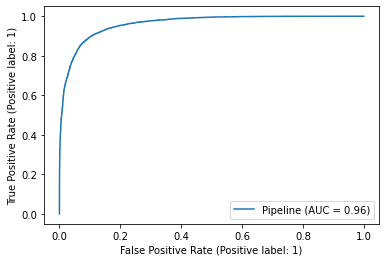

In [274]:
xgc_scoring.plt_roc_curve()

#### Stacking Classifier 

In [319]:
stc = StackingClassifier(estimators=[('log_reg', LogisticRegression(max_iter=1000)),
    ('gbc', GradientBoostingClassifier(random_state=42)),
    
    
])
stc_pipe= Pipeline([('total_preprocessing',total_preprocessing), ('stc', stc)])

In [320]:
stc_pipe.fit(X_train,y_train);

In [321]:
stc_scoring=ModelWithAOCROC(stc_pipe, 'stc_pipe', X_train, y_train, cv_now=True)

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:985: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:990: RuntimeWarning: invalid value encountered in true_divide
  T = new_sum / new_sample_count
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:1020: RuntimeWarning: invalid value encountered in true_divide
  new_unnormalized_variance -= correction ** 2 / new_sample_count
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:81: RuntimeWarning: invalid value encountered in less_equal
  return var <= upper_bound


In [322]:
stc_scoring.print_cv_summary()

CV Results for `stc_pipe` model:
            0.78673 ± 0.00768 accuracy
        


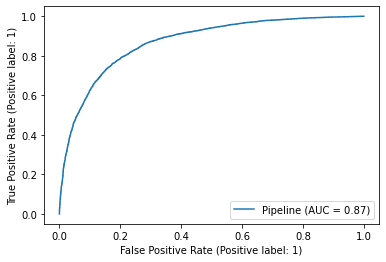

In [323]:
stc_scoring.plt_roc_curve()

#### Stacking Classifier 2

In [310]:
stc2 = StackingClassifier(estimators=[(('rfe_logreg',selector)),
    ('xgc',  XGBClassifier(random_state=42, objective='binary:logistic')),
    
    
])
stc2_pipe= Pipeline([('total_preprocessing',total_preprocessing), ('stc2', stc2)])

In [311]:
stc2_pipe.fit(X_train,y_train);

In [312]:
stc2_scoring=ModelWithAOCROC(stc2_pipe, 'stc2_pipe', X_train, y_train, cv_now=False)

In [313]:
stc2_scoring.cross_validate(kfolds=3)

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:985: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:990: RuntimeWarning: invalid value encountered in true_divide
  T = new_sum / new_sample_count
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/utils/extmath.py:1020: RuntimeWarning: invalid value encountered in true_divide
  new_unnormalized_variance -= correction ** 2 / new_sample_count
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:81: RuntimeWarning: invalid value encountered in less_equal
  return var <= upper_bound


In [314]:
stc2_scoring.print_cv_summary()

CV Results for `stc2_pipe` model:
            0.77181 ± 0.00274 accuracy
        


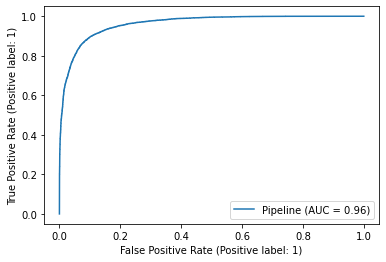

In [315]:
stc2_scoring.plt_roc_curve()

### Pre-Processing #2 Results Table

| Model Name      | AOC |
| -----------  | ----------- |
| Dummy Class  |0.50         |
| Log_Reg      |0.53         |
| KNN          |0.92         |
| Decision T   |1.00         |
|  RTC         |1.00         |
| Extra Trees  |1.00         |
| Bagging      |1.00         |
|GradientBoost |0.87         |
| XG Boost     |0.96         |
|GBC& LoR Stack|0.87         |
|XG & LoR Stack|0.96             |

These results are the exact same so the different column transformer does absolutely nothing. the final model is the stacking qualifier with Gradient Boosting and Logistic Regression because its score it high but not too high and we worry about over-fitting. Its also much better than the dummy classifier and much less computationally expensive than the last stacking classifier. 

## Final Model Evaluation

In [326]:
#define final model
final_model = stc_pipe

In [333]:
#fit to train
final_model.fit(X_train,y_train);

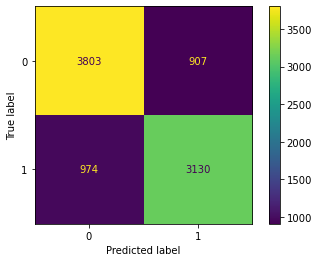

In [330]:
plot_confusion_matrix(final_model, X_test, y_test);

In [331]:
#predict with X test and get preds
y_hat = final_model.predict(X_test)

In [332]:
print(f"""
Our final model's accuracy on the test set is {round(accuracy_score(y_test, y_hat), 2)}. \n
Our final model's recall on the test set is {round(recall_score(y_test, y_hat), 2)} \n
Our final model's precision on the test set is {round(precision_score(y_test, y_hat), 2)} \n
Our final model's f1-score on the test is {round(f1_score(y_test, y_hat), 2)}.
""")


Our final model's accuracy on the test set is 0.79. 

Our final model's recall on the test set is 0.76 

Our final model's precision on the test set is 0.78 

Our final model's f1-score on the test is 0.77.



## Conclusion and Recommendations

So finally how can our model help you? Inferentially, it can give you an understanding of which factors most influence vaccines demand the most,  Predictively it uses those same factors to classify vaccinated and unvaccinated participants with an 81% accuracy. This will help to reduce those costs associated with the business problem because demand can be more accurately forecasted, this will a more consistent and manageable supply of vaccines in the supply chain.  

Our first recommendation would be to use my model to predict and anticipate the needs of the public, hopefully, this will mitigate vaccine wastage and prevent any dire shortages such as the one in 2004-2005 (Ref).Our second recommendation is to target outreach programs to the lower-income groups, neighborhoods with minorities and individuals that don't have access to health insurance and promote evidence-based scientific knowledge. Furthermore, we want to recommend being a part of the conversation and debunking misinformed theories with scientific evidence grown in house. Utilizing the power of social media could dramatically impact vaccination rate.


## Next Steps

Finally, some next steps we would like to reconfigure the model with more historical data as well as more behavioral data, available on the CDC and WHO websites.  I would also love to find a way to quantify the impact of misinformation.Eventually, this model will serve as the foundation for a publicly available dashboard that updates in real-time with real-time inputs. This would be serve as great starting point for any future vaccine roll-outs.We're so  excited to be a part of this journey to a more inoculated, more informed America.  

## References and Resources 